In [ ]:
FLAG_COLAB = True

# Подготовка

In [ ]:
if FLAG_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install ultralytics
  !pip install shapely
  # !pip install pillow
  FLAG_COLAB = False
import json
from ultralytics import YOLO
from ultralytics.models.sam import Predictor as SAMPredictor
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from shapely.geometry import Polygon, LinearRing, LineString
import gc
import torch
import torchvision

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Константы

In [ ]:

PATH_BEGIN_IMAGE = "/content/drive/MyDrive/images/render1.png"
PATH_WEIGHTS_YOLO = '/content/drive/MyDrive/yolov8l.pt 2.0 /runs4 best 0.751 /detect/train4/weights/best.pt'
PATH_WEIGHTS_SAM = '/content/drive/MyDrive/SAM/sam_b.pt'

# Размеры ленты калиборованные реальные в метрах
lenta_real_left = 3.44579
lenta_real_right = 3.19624
lenta_real_up = 0.803967
lenta_real_down = 0.800971
lenta_real_wight = 0.8007
lenta_real_camera_lenght = 1.10854
# Откалиброванные границы ленты пиксели ленты, легко калибруются с клиента
arr_lenta_left = np.array([[164,0],[190,640]])
arr_lenta_right = np.array([[640,509],[327,0]])
arr_lenta_up = np.array([[164,0],[327,0]])
arr_lenta_down = np.array([[640,509],[190,640]])

# perspective_coef = calculate_perspective_coef()

In [ ]:
def clean_memory_for_gpu():
  torch.cuda.empty_cache()
  gc.collect()

# Детекция

In [ ]:
def detection(path_weights: str = PATH_WEIGHTS_YOLO,\
              path_image: str = PATH_BEGIN_IMAGE,\
              conf: float = 0.75) -> list:
  """Метод детекции упаковки
  Parameters
  ----------
  path_weights: str = PATH_WEIGHTS_YOLO
  path_image: str = PATH_BEGIN_IMAGE
  conf: float = 0.75
  """
  model = YOLO(path_weights)
  result = model.predict(source=path_image,\
        save = True, \
        conf = conf,\
        )
  return result



# Сегментация

In [ ]:
# TODO: доделать параметры вынести модель в константу
def segmentation_bboxes(image, bboxes):
  """Метод сегментации упаковки по bbox
  Parameters
  ----------
  # image - np.array image (result[0].orig_img)
  """
  overrides = dict(conf=0.99,  task='segment', mode='predict',  model=PATH_WEIGHTS_SAM)
  predictor = SAMPredictor(overrides=overrides)
  predictor.set_image(image)
  # bboxes = list(box.values())
  result = predictor(bboxes = bboxes)
  return result


def segmentation(image):
  """Метод сегментации
  Parameters
  ----------
  # image - np.array image (result[0].orig_img)
  """
  overrides = dict(conf=0.99,  task='segment', mode='predict',  model=PATH_WEIGHTS_SAM, save_crop  = True )
  predictor = SAMPredictor(overrides=overrides)
  predictor.set_image(image)
  result = predictor()
  return result


# Вывод изображений

In [ ]:
def show_image_after_ultralytics(result: list):
  """Метод вывода изображения после применения модели
  Parameters
  ----------
  result: list
  результат после применения модели
  """
  image = Image.open(result[0].save_dir + '/' + \
                     result[0].path.split('/')[-1])
  plt.imshow(image)
  plt.show()

In [ ]:
def show_image(img: list):
  """Метод вывода изображения np
  """
  plt.imshow(img)
  plt.show()

# Экспотр bbox

In [ ]:
def result_to_json(result):
  """Экспорт данных из result в json
  Parameters
  ----------
  result: list
  результат после применения модели
  ----------
  """
  for r in result:
    print(r.tojson())

  j = json.loads(json.dumps(r.tojson()))
  return j


def get_bbox_from_result(j):
  """Получить данные bbox из json в формате [x1,y1,x2,y2]"""
  box = json.loads(j)[0]['box']
  print(list(box.values()))
  return list(box.values())


# Подготовка сегментированных данных для повторной сегментации на более мелкие объекты

In [ ]:
def preparing_for_detailed_segmentation(result, crop: bool = False, bgcolor:str = "white"):
  """Подготовка для сегментации боковых граней(уменьшение размерности, удаление лишних элементов)
  Возвращает изображение в формате np
  Параметр:

  """
  for r in result:
      img = np.copy(r.orig_img)
      img_name = Path(r.path).stem

      # iterate each object contour
      for ci,c in enumerate(r):
          # Create contour mask
          contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)

          # OPTION-3: черный фон
          if(bgcolor == "black"):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            isolated = cv2.bitwise_and(mask3ch, img)

          # OPTION-2: прозрачный фон # Белый фон эффективнее из-за внутренних алгоритмов
          if(bgcolor == "white"):
            white_bg = np.ones_like(img) * 255
            cv2.drawContours(white_bg, [contour], -1, (0, 0, 0), thickness=cv2.FILLED)
            isolated = cv2.bitwise_or(white_bg, img)

          # OPTION-3: прозрачный фон на стадии распознования убирает альфа канал и изображение остается неизменным
          # isolated = np.dstack([img, b_mask])

          bbx1, bby1, bbx2, bby2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
          iso_crop = isolated[bby1:bby2, bbx1:bbx2]
          _ = cv2.imwrite(f'segcrop{ci}.png', isolated)
          print(f'segcrop{ci}.png сохранено на диск')

          if(crop):
            return iso_crop
          else:
            return isolated

#Сегментация граней

In [ ]:
def segmentation_of_the_side(result, crop: bool = False, bgcolor:str = "white"):
  img = preparing_for_detailed_segmentation(result, crop, bgcolor)
  show_image(img)
  result = segmentation(img)
  return result

# Рисуем контуры в матплотлибе

In [ ]:
def draw_point_cloud_edges(xy: list, size: list = [640,640]):
  fig = plt.figure()
  ax = plt.axes()

  plt.xlim([0, size[0]])
  plt.ylim([-size[1], 10])#-640, 0  , 10потому что не видно врезнюю границу

  x1, y1, x2, y2, x3, y3 = xy

  # точки граней
  ax.scatter(x1, y1, 0.1)
  ax.scatter(x2, y2, 0.1)
  ax.scatter(x3, y3, 0.1)

  # # контуры граней
  # plt.plot(x1, y1)
  # plt.plot(x2, y2)
  # plt.plot(x3, y3)

  # границы ленты
  plt.plot(arr_lenta_left[:,0] , -arr_lenta_left[:,1])
  plt.plot(arr_lenta_right[:,0] , -arr_lenta_right[:,1])
  plt.plot(arr_lenta_down[:,0] , -arr_lenta_down[:,1])
  plt.plot(arr_lenta_up[:,0] , -arr_lenta_up[:,1])

  plt.show()


# Расчет коэфициента изометрической проекции

In [ ]:
def calculate_perspective_coef():
  def distance(xs, ys):
    return np.sqrt((xs[0] - xs[1]) ** 2 + (ys[0] - ys[1]) ** 2)

  coef_perspectiva = distance(arr_lenta_down[:,0],-arr_lenta_down[:,1]) / distance(arr_lenta_up[:,0] , -arr_lenta_up[:,1])
  return coef_perspectiva

In [ ]:
def get_xy_edges(result, bbox):
  # for r in result:
  #   print(len(r.masks.xy[0]))
  #   print(len(r.masks.xy[1]))
  #   print(len(r.masks.xy[2]))
  #   print(len(r.masks.xy[3]))
  r = result[0]

  bbx1, bby1 = bbox[0], bbox[1]
# TODO: Нужно определить нужные индексы координат для граней, возможно ошибочное выделение
  x1, y1 = bbx1 + np.array(r.masks.xy[-3])[:,0],-(np.array(r.masks.xy[-3])[:,1] + bby1)
  x2, y2 = bbx1 + np.array(r.masks.xy[-2])[:,0],-(np.array(r.masks.xy[-2])[:,1] + bby1)
  x3, y3 = bbx1 + np.array(r.masks.xy[-1])[:,0],-(np.array(r.masks.xy[-1])[:,1] + bby1)

  point_cloud = [x1,y1,x2,y2,x3,y3]

  print(len(x1), len(y1))
  print(len(x2), len(y2))
  print(len(x3), len(y3))

  return point_cloud

In [ ]:
def approximate_point_cloud(xy: list, size: list = [640,640]):
  x1,y1,x2,y2,x3,y3 = point_cloud

  line_strings_all = []
  line_strings_all.append(simplify_polygon(np.c_[x1,y1], epsilon = 5))
  line_strings_all.append(simplify_polygon(np.c_[x2,y2], epsilon = 5))
  line_strings_all.append(simplify_polygon(np.c_[x3,y3], epsilon = 5))

  return line_strings_all


def draw_edges(line_strings_all: list, size: list = [640,640]):
  def draw_line_strings(line_strings):
    x_line, y_line = [],[]
    for l in line_strings:
      x_line += l.xy[0]
      y_line += l.xy[1]
    y_line[:] = [-i for i in y_line]
    plt.plot(x_line, y_line,  'o-')

  fig = plt.figure()
  ax = plt.axes()
  # plt.xlim([0, size[0]])
  # plt.ylim([-size[1], 10])#-640, 0  , 10потому что не видно врезнюю границу

  for line_strings in line_strings_all:
    draw_line_strings(line_strings)

  # границы ленты
  plt.plot(arr_lenta_left[:,0] , arr_lenta_left[:,1])
  plt.plot(arr_lenta_right[:,0] , arr_lenta_right[:,1])
  plt.plot(arr_lenta_down[:,0] , arr_lenta_down[:,1])
  plt.plot(arr_lenta_up[:,0] , arr_lenta_up[:,1])
  # Открываем изображение с помощью Pillow
  image = Image.open(PATH_BEGIN_IMAGE)
  # Наложение графика на изображение
  plt.imshow(image)

  plt.show()




# Апроксимация облака точек

### методом аппроксимации многоугольника с помощью прямых отрезков, например, методом Рамера-Дугласа-Пекера ТОП(Можно дропать маленькие участки и достаривать большие отрезки в зависимости от ситуации)

- Для упрощения многоугольника до четырехугольника с минимальными потерями информации можно воспользоваться методом аппроксимации многоугольника с помощью прямых отрезков, например, методом Рамера-Дугласа-Пекера (Ramer-Douglas-Peucker). Этот метод позволяет уменьшить количество вершин многоугольника, оставляя только самые значимые точки.

In [ ]:

 # находим четыре самых больших отрезка и ищем где они последовательное соединены мелочью, затем дропаем мелочь и ищем где пересекаются большие

def simplify_polygon(points, epsilon):
    """ Упрощение многоугольника с помощью метода Рамера-Дугласа-Пекера сводит к 4тырем сторонам"""
    # Упрощение линии с помощью метода Рамера-Дугласа-Пекера
    ring = LinearRing(points).simplify(epsilon)

    # Вершины упрощенного многоугольника -1 так как последняя координата повторяется
    xy = np.c_[np.array(ring.coords)]

    line_strings = drop_small_line(xy)
    line_strings = prolongation_segments(line_strings)
    line_strings = cut_at_intersection(line_strings)

    return line_strings


def drop_small_line(xy):
    """ Возвращает набор 4-рех ребер LineString (сведение до четырехугольника)"""
    #вынесем в отдельный список набор LineString
    xy_line_lenght = []
    for i in range(len(xy) - 1):
      line = LineString([xy[i], xy[i + 1]])
      xy_line_lenght.append([line.length, line])

    #найдем 4 самых больших ребра, дропнем мелочь
    while len(xy_line_lenght) != 4:
      xy_line_lenght.remove(min(xy_line_lenght))

    #пересоздадим массив без длинны ребер
    xy_line_lenght = np.array(xy_line_lenght)
    xy_line_lenght = xy_line_lenght[:,1]

    return xy_line_lenght


def prolongation_segments(line_strings):
    """ Возвращает масштабированный набор ребер в формате LineString"""
    #интреполируем отрезки с обоих сторон что бы потом обрезать в пересечениях условно на своюэе длинну
    for i in range(len(line_strings)):
      c = list(line_strings[i].coords)

      p1 = [c[0][0] * 2 - c[1][0], c[0][1] * 2 - c[1][1]]
      p2 = [c[1][0] * 2 - c[0][0], c[1][1] * 2 - c[0][1]]
      line_strings[i] = LineString([p1,p2])
      x_line, y_line = line_strings[i].xy
    return line_strings


def cut_at_intersection(line_strings):
    """ Обрезает прямые по ресечениям до четырехугольника"""
    l = []
    for i in range(len(line_strings)):
      if (i == len(line_strings) - 1):
        points = line_strings[i].intersection([line_strings[i - 1], line_strings[0]])
      else:
        points = line_strings[i].intersection([line_strings[i - 1], line_strings[i + 1]])
      l.append(LineString([points[0].coords[0], points[1].coords[0]]))

    return l

#Применение


image 1/1 /content/drive/MyDrive/images/render1.png: 640x640 1 package, 63.4ms
Speed: 3.0ms preprocess, 63.4ms inference, 624.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


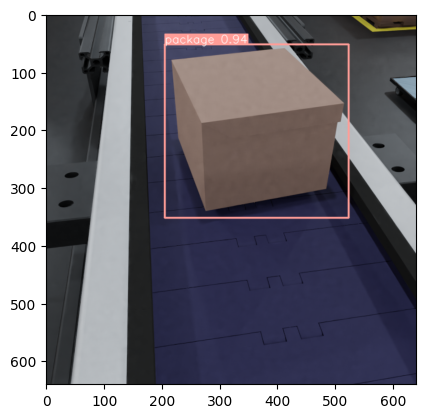

[
  {
    "name": "package",
    "class": 1,
    "confidence": 0.939598023891449,
    "box": {
      "x1": 205.0914306640625,
      "y1": 52.09014892578125,
      "x2": 523.1130981445312,
      "y2": 352.80157470703125
    }
  }
]
[205.0914306640625, 52.09014892578125, 523.1130981445312, 352.80157470703125]
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

0: 1024x1024 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict13


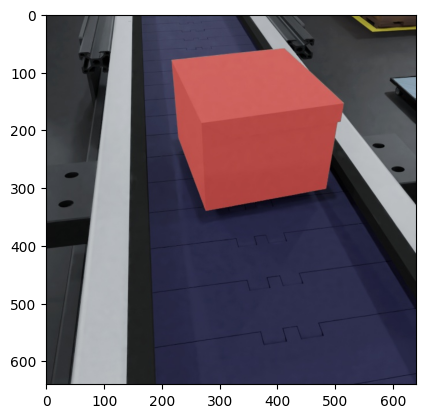

In [ ]:
result = detection()
show_image_after_ultralytics(result)

clean_memory_for_gpu()

bbox = get_bbox_from_result(result_to_json(result))
result = segmentation_bboxes(result[0].orig_img, bbox)
show_image_after_ultralytics(result)



In [ ]:
clean_memory_for_gpu()

segcrop0.png сохранено на диск


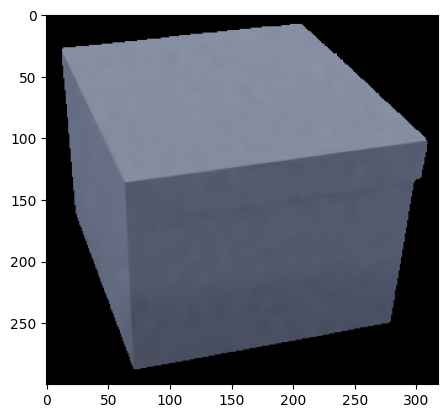

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 4202.0ms
Speed: 0.1ms preprocess, 4202.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict15


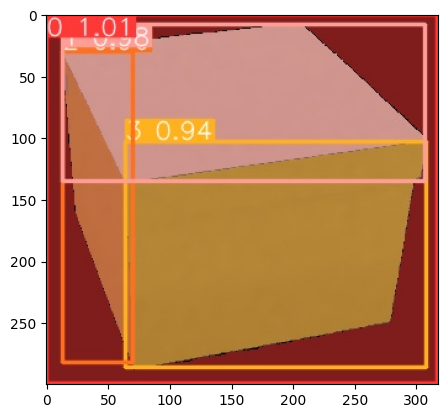

In [ ]:

result_side = segmentation_of_the_side(result, crop = True, bgcolor = 'black')
show_image_after_ultralytics(result_side)


221 221
207 207
217 217


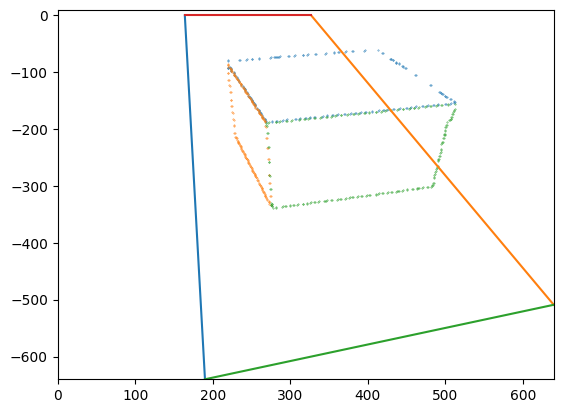

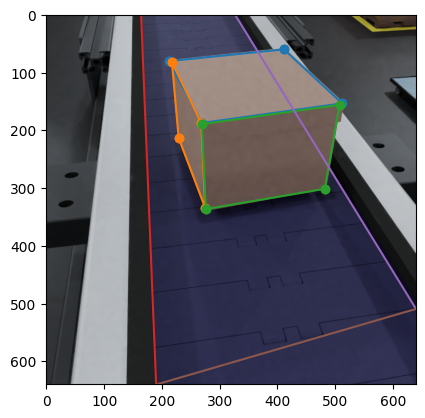

In [ ]:
point_cloud = get_xy_edges(result_side, bbox)#TODO bbox если кроп передавать нормаьный bbox сделать проверку
draw_point_cloud_edges(point_cloud)# TODO: передать размеры изображения аргументом


line_strings_all = approximate_point_cloud(point_cloud, size = [640,640])
draw_edges(line_strings_all, size = [640,640])

In [ ]:
clean_memory_for_gpu()

In [ ]:
print(line_strings_all)
# Формируем словарь граней c координатами
sides_dict = {"sides":[]}
for i, side in enumerate(line_strings_all):
  edge_dict = {"edges":[]}
  for j, edge in enumerate(side):
    edge_dict[f"edges"].append({f"line": {'xy': [[edge.xy[0][0], edge.xy[1][0]], [edge.xy[0][1], edge.xy[1][1]]],\
                                          "centoroid": {'xy' : [edge.centroid.xy[0][0],edge.centroid.xy[1][0]]}}})
  sides_dict[f"sides"].append(edge_dict)

# Формируем словарь граней c нормальными


# добавляем на будущее словарь центрроидов грани
sides_dict

[[<LINESTRING (411.406 -59.524, 212.08 -79.909)>, <LINESTRING (212.08 -79.909, 269.091 -187.09)>, <LINESTRING (269.091 -187.09, 512.091 -153.09)>, <LINESTRING (512.091 -153.09, 411.406 -59.524)>], [<LINESTRING (217.337 -81.438, 229.091 -213.09)>, <LINESTRING (229.091 -213.09, 275.091 -334.09)>, <LINESTRING (275.091 -334.09, 268.091 -187.09)>, <LINESTRING (268.091 -187.09, 217.337 -81.438)>], [<LINESTRING (507.617 -155.595, 269.091 -189.09)>, <LINESTRING (269.091 -189.09, 276.091 -336.09)>, <LINESTRING (276.091 -336.09, 482.091 -301.09)>, <LINESTRING (482.091 -301.09, 507.617 -155.595)>]]


{'sides': [{'edges': [{'line': {'xy': [[411.40599614753864,
        -59.52388654678937],
       [212.08042401421156, -79.90945642406146]],
      'centoroid': {'xy': [311.7432100808751, -69.71667148542542]}}},
    {'line': {'xy': [[212.08042401421156, -79.90945642406146],
       [269.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [240.58592733913704, -133.49980267492134]}}},
    {'line': {'xy': [[269.0914306640625, -187.09014892578125],
       [512.0914306640625, -153.09014892578125]],
      'centoroid': {'xy': [390.5914306640625, -170.09014892578125]}}},
    {'line': {'xy': [[512.0914306640625, -153.09014892578125],
       [411.40599614753864, -59.52388654678937]],
      'centoroid': {'xy': [461.7487134058006, -106.3070177362853]}}}]},
  {'edges': [{'line': {'xy': [[217.33673057453697, -81.43750792309548],
       [229.0914306640625, -213.09014892578125]],
      'centoroid': {'xy': [223.21408061929975, -147.26382842443837]}}},
    {'line': {'xy': [[229.0914306640625, -2

In [ ]:
{'sides': [{'edges': [{'line': {'xy': [[411.40599614753864,
        -59.52388654678937],
       [212.08042401421156, -79.90945642406146]],
      'centoroid': {'xy': [311.7432100808751, -69.71667148542542]}}},
    {'line': {'xy': [[212.08042401421156, -79.90945642406146],
       [269.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [240.58592733913704, -133.49980267492134]}}},
    {'line': {'xy': [[269.0914306640625, -187.09014892578125],
       [512.0914306640625, -153.09014892578125]],
      'centoroid': {'xy': [390.5914306640625, -170.09014892578125]}}},
    {'line': {'xy': [[512.0914306640625, -153.09014892578125],
       [411.40599614753864, -59.52388654678937]],
      'centoroid': {'xy': [461.7487134058006, -106.3070177362853]}}}]},
  {'edges': [{'line': {'xy': [[217.33673057453697, -81.43750792309548],
       [229.0914306640625, -213.09014892578125]],
      'centoroid': {'xy': [223.21408061929975, -147.26382842443837]}}},
    {'line': {'xy': [[229.0914306640625, -213.09014892578125],
       [275.0914306640625, -334.09014892578125]],
      'centoroid': {'xy': [252.0914306640625, -273.59014892578125]}}},
    {'line': {'xy': [[275.0914306640625, -334.09014892578125],
       [268.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [271.5914306640625, -260.59014892578125]}}},
    {'line': {'xy': [[268.0914306640625, -187.09014892578125],
       [217.33673057453697, -81.43750792309548]],
      'centoroid': {'xy': [242.71408061929975, -134.26382842443837]}}}]},
  {'edges': [{'line': {'xy': [[507.6168803387659, -155.59508577997184],
       [269.0914306640625, -189.09014892578125]],
      'centoroid': {'xy': [388.3541555014142, -172.34261735287654]}}},
    {'line': {'xy': [[269.0914306640625, -189.09014892578125],
       [276.0914306640625, -336.09014892578125]],
      'centoroid': {'xy': [272.5914306640625, -262.59014892578125]}}},
    {'line': {'xy': [[276.0914306640625, -336.09014892578125],
       [482.0914306640625, -301.09014892578125]],
      'centoroid': {'xy': [379.0914306640625, -318.59014892578125]}}},
    {'line': {'xy': [[482.0914306640625, -301.09014892578125],
       [507.6168803387659, -155.59508577997184]],
      'centoroid': {'xy': [494.8541555014142, -228.34261735287652]}}}]}]}

In [ ]:
sides_dict['sides'][0]['edges'][0]['line']['xy']

[[411.40599614753864, -59.52388654678937],
 [212.08042401421156, -79.90945642406146]]

In [ ]:
centroids = []

for i in sides_dict['sides']:
  c = []
  for j in i['edges']:
    c.append(j['line']['centoroid']['xy'])
  centroids.append(c)
centroids

[[[311.7432100808751, -69.71667148542542],
  [240.58592733913704, -133.49980267492134],
  [390.5914306640625, -170.09014892578125],
  [461.7487134058006, -106.3070177362853]],
 [[223.21408061929975, -147.26382842443837],
  [252.0914306640625, -273.59014892578125],
  [271.5914306640625, -260.59014892578125],
  [242.71408061929975, -134.26382842443837]],
 [[388.3541555014142, -172.34261735287654],
  [272.5914306640625, -262.59014892578125],
  [379.0914306640625, -318.59014892578125],
  [494.8541555014142, -228.34261735287652]]]

AttributeError: 'dict' object has no attribute 'xy'

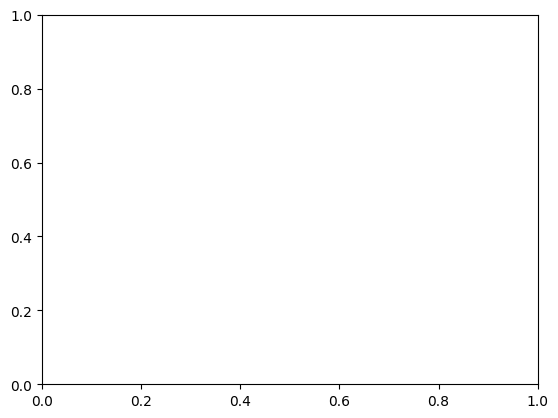

In [ ]:
# Можно срастить ребра в отдельном классе по минимальному отклонению


In [ ]:
centroids_dict

{0: {0: <POINT (311.743 -69.717)>,
  1: <POINT (240.586 -133.5)>,
  2: <POINT (390.591 -170.09)>,
  3: <POINT (461.749 -106.307)>},
 1: {0: <POINT (223.214 -147.264)>,
  1: <POINT (252.091 -273.59)>,
  2: <POINT (271.591 -260.59)>,
  3: <POINT (242.714 -134.264)>},
 2: {0: <POINT (388.354 -172.343)>,
  1: <POINT (272.591 -262.59)>,
  2: <POINT (379.091 -318.59)>,
  3: <POINT (494.854 -228.343)>}}

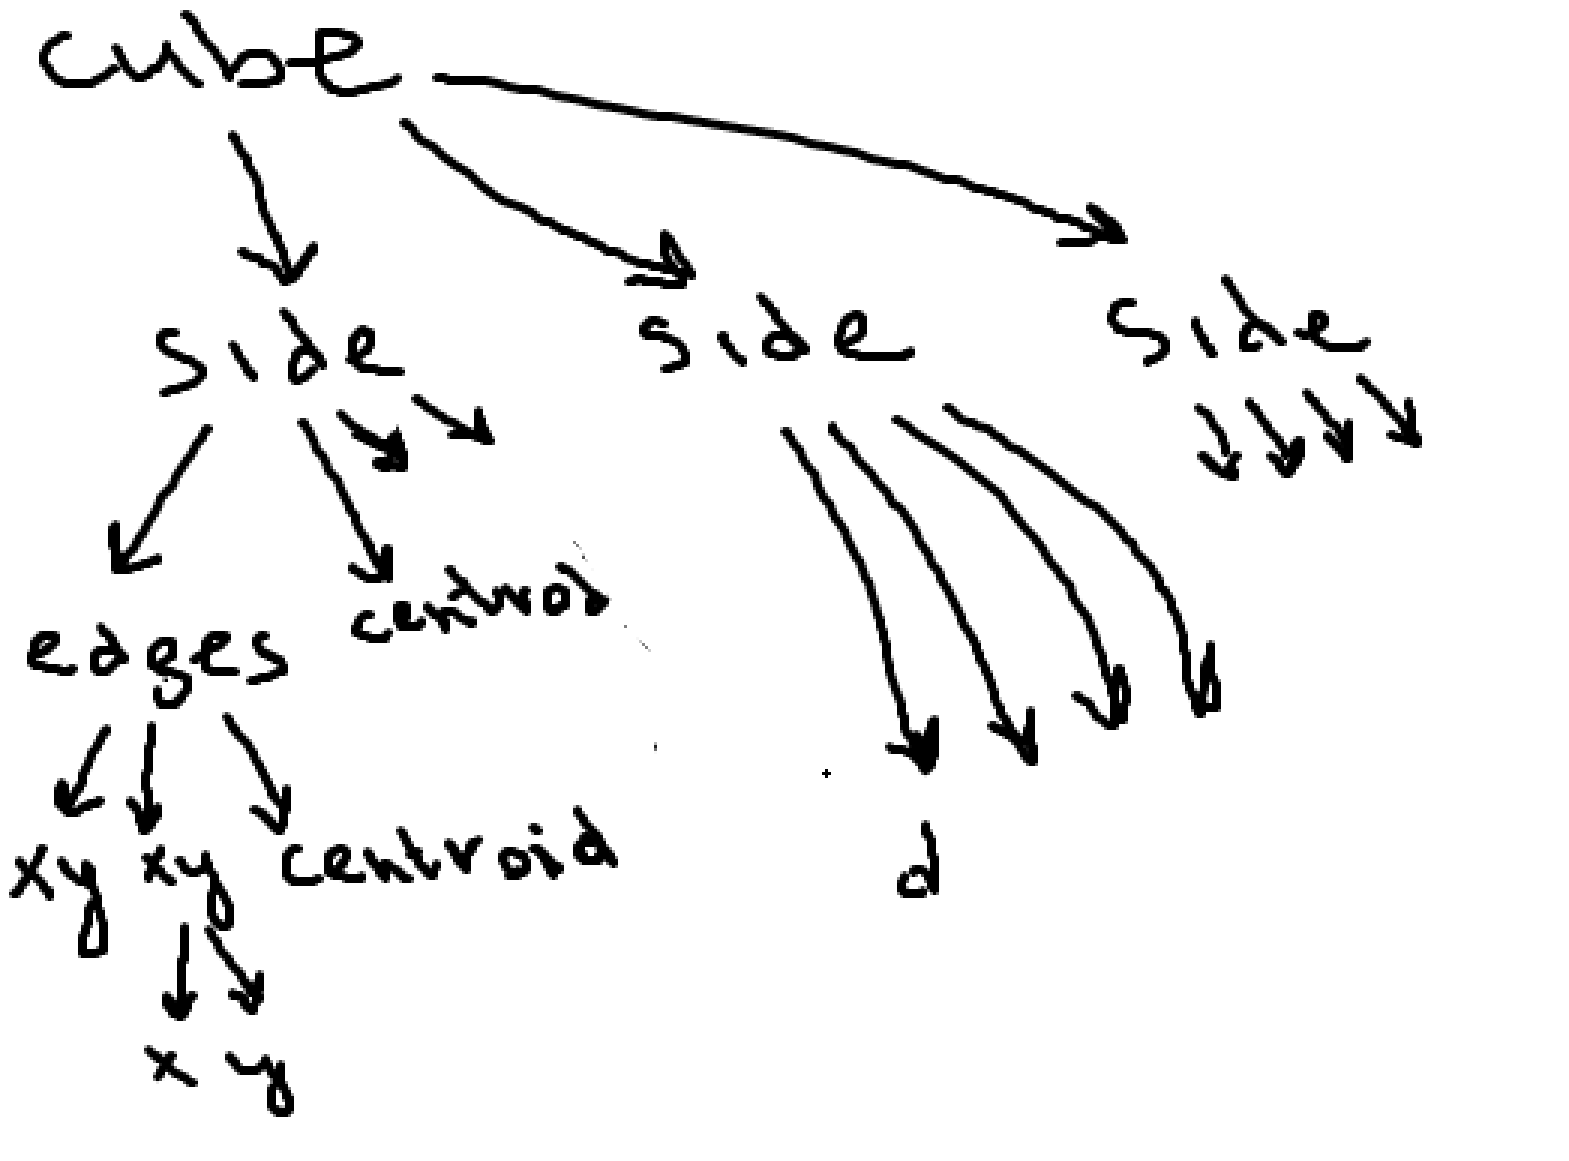

In [ ]:
for i in centroids_dict:
  print(i)

# print(centroids_dict[0][0].xy[1][0])

# min_y_centroid = centroids_dict[0][0].xy[1][0]
# min_y_centroid_xy = []
# for i, side in enumerate(line_strings_all):
#   for j, edge in enumerate(side):
#     if edge.xy[1][0] < min_y_centroid:
#       min_y_centroid = edge.xy[1][0]



0
1
2
-69.71667148542542
